## AI Hack - Crop Yield Challenge

**Challenge Description:**

For this challenge, you will be tackling one of the world's most important challenges: modelling crop yields. Climate change is having a big impact in global food security, whilst Earth's population, in particular, in the developing world, continues to grow. Extreme weather events can have significant [impacts](http://www.nature.com/articles/nclimate1832) on crops and there is (significant evidence)[https://www.metoffice.gov.uk/weather/climate/climate-and-extreme-weather] showing that, recently, extreme events have become (1) more extreme and (2) more frequent, making crop yield modelling a useful tool for policy makers and suppliers who are hoping to mitigate these devastating risks.

From a machine learning and statistical perspective, crop yield modelling is a challenging task that can be seen as a **weakly supervised learning** or **multiple instance learning** problem. For every year and census region (e.g. county), we can gather an abundance of features such as daily temperature, vegetation indices and soil moisture, but we only have access to 1 crop yield label. To perform regression, one usually requires the dataset $\{(x_i,y_i)\}_{i=1}^n$. In this case, however, we have $\{(\{x_{ij}\}_{j=1}^{N_i},y_i)\}_{i=1}^n$, where $N_i$ is the number of feature vectors available for label $y_i$. A naive approach would be to reduce to the former by averaging the covariates $\bar{x}_{i}=\sum_{j=1}^{N_i} x_{ij}$, but this may result in an enormous loss of information. 

Could you explore different approaches to modelling crop yields using the provided datasets?

**Data:**

You are provided with various cleaned datasets that are extracted from the State of Illinois, USA. 

- [ ] `IL_yield.csv` contains corn yields for various census counties in Illinois
- [ ] `illinois-counties.geojson` contains the geometries of counties in Illinois
- [ ] `EVI.csv` contains [Enhanced Vegetation Indices](https://en.wikipedia.org/wiki/Enhanced_vegetation_index) for pixels extract from [The Terra Moderate Resolution Imaging Spectroradiometer (MODIS) Vegetation Indices (MOD13Q1)](https://lpdaac.usgs.gov/products/mod13q1v006/) product, aggregated at the resolution of the pixels in the [The Terra and Aqua combined Moderate Resolution Imaging Spectroradiometer (MODIS) Land Cover Climate Modeling Grid (CMG) (MCD12C1)](https://lpdaac.usgs.gov/products/mcd12c1v006/) product that indicate `Majority_Land_Cover_Type_1` is a cropland. The EVI is observed every 16 days.
- `EVI_stacked.csv` is the same as `EVI.csv` except the data is stacked to include the EVI observations for each 16 days in the column.
- `ERA5.csv` contains 2m temperature readings from [ERA5 Renalaysis](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=overview), "the fifth generation ECMWF reanalysis for the global climate and weather for the past 4 to 7 decades". More information about the variable can be found in the link given.

**Recommended Reading:**
- https://ojs.aaai.org/index.php/AAAI/article/view/11172/11031&hl=en&sa=T&oi=gsb-gga&ct=res&cd=0&d=1880767705414439608&ei=6kgwYPHHCvGTy9YPmJeAsAk&scisig=AAGBfm0LS8pg3jC6MJQQE5-vz3M2kSQeDg
- https://aiforsocialgood.github.io/icml2019/accepted/track1/pdfs/20_aisg_icml2019.pdf
- http://proceedings.mlr.press/v80/ilse18a/ilse18a.pdf
- https://linkinghub.elsevier.com/retrieve/pii/S0034425711002926
- https://linkinghub.elsevier.com/retrieve/pii/S0034425719304791
- https://ieeexplore.ieee.org/document/9173550/
- https://royalsocietypublishing.org/doi/10.1098/rstb.2019.0510 
- http://www.nature.com/articles/nclimate1832
- http://www.nature.com/articles/nature16467
- https://royalsocietypublishing.org/doi/10.1098/rstb.2019.0510

**Suggestions:**

- [ ] It will be useful to make use of `pandas`, `geopandas` and `matplotlib` for data processing and visualisation.
- [ ] Be as creative and rigorous as possible with how you make use of the features.
- [ ] Try and take some time to read through the various papers on the recommended reading list.
- [ ] I recommend only using features between April - November 2015, as suggestioned by one of the papers on the list https://www.sciencedirect.com/science/article/pii/S0034425719304791?via%3Dihub. 


Good luck - we hope that you enjoy this challenge and look forward to seeing your submissions on Devpost!

In [10]:
!ls .

'ls' is not recognized as an internal or external command,
operable program or batch file.


## An illustrative plot

In [31]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sklearn
import numpy as np


In [5]:
gdf = gpd.read_file("data/illinois-counties.geojson")
stacked_df = pd.read_csv("data/EVI_stacked.csv")
EVI_df = pd.read_csv("data/EVI.csv")  # necessary?
ERA5_df = pd.read_csv("data/ERA5.csv")
yield_df = pd.read_csv("data/IL_yield.csv")

First preprocessing the data, turning date values to pd.date_time variables:

In [11]:
ERA5_df['time'] = pd.to_datetime(ERA5_df['time'])


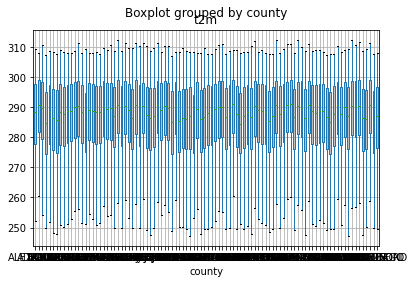

In [9]:
ERA5_df.boxplot(column='t2m', by='county')

In [12]:
ERA5_df.head()

,lat,long,time,t2m,county
0,42.5,-90.5,1989-01-01,268.996185,JO DAVIESS
1,42.5,-90.5,1989-01-15,271.925720,JO DAVIESS
2,42.5,-90.5,1989-01-28,276.593048,JO DAVIESS
3,42.5,-90.5,1989-02-01,282.042358,JO DAVIESS
4,42.5,-90.5,1989-02-15,269.375763,JO DAVIESS


In [13]:
red_ERA5 = ERA5_df.copy()
red_ERA5 = red_ERA5.drop(['lat', 'long'], axis=1)

In [14]:
#red_ERA5.time.dt.year()
red_ERA5['year']=pd.DatetimeIndex(red_ERA5['time']).year
red_ERA5

,time,t2m,county,year
0,1989-01-01,268.996185,JO DAVIESS,1989
1,1989-01-15,271.925720,JO DAVIESS,1989
2,1989-01-28,276.593048,JO DAVIESS,1989
3,1989-02-01,282.042358,JO DAVIESS,1989
4,1989-02-15,269.375763,JO DAVIESS,1989
...,...,...,...,...
328675,2012-11-15,278.565491,PULASKI,2012
328676,2012-11-28,274.160889,PULASKI,2012
328677,2012-12-01,285.636108,PULASKI,2012
328678,2012-12-15,282.508789,PULASKI,2012


In [15]:
avg_ERA5_graphic = ERA5_df.groupby(['county'],as_index=False).mean()

In [16]:
avg_ERA5_graphic

,county,lat,long,t2m
0,ADAMS,40.000,-91.125,287.271928
1,ALEXANDER,37.250,-89.250,289.934753
2,BOND,38.875,-89.500,288.651612
3,BOONE,42.250,-88.750,284.372711
4,BROWN,40.000,-90.750,287.209720
...,...,...,...,...
91,WHITESIDE,41.750,-89.875,285.411081
92,WILL,41.500,-88.125,285.435388
93,WILLIAMSON,37.750,-88.875,289.757193
94,WINNEBAGO,42.250,-89.125,284.616398


In [17]:
avg_ERA5 = red_ERA5.groupby(['county', 'year'],as_index=False).mean()
#red_ERA5.set_index('time')
avg_ERA5

,county,year,t2m
0,ADAMS,1979,284.440480
1,ADAMS,1980,286.384519
2,ADAMS,1981,288.671996
3,ADAMS,1982,286.722131
4,ADAMS,1983,287.189423
...,...,...,...
3835,WOODFORD,2015,286.044988
3836,WOODFORD,2016,287.490755
3837,WOODFORD,2017,286.895042
3838,WOODFORD,2018,287.693067


Text(0.5, 1.0, 'Average time to maturity')

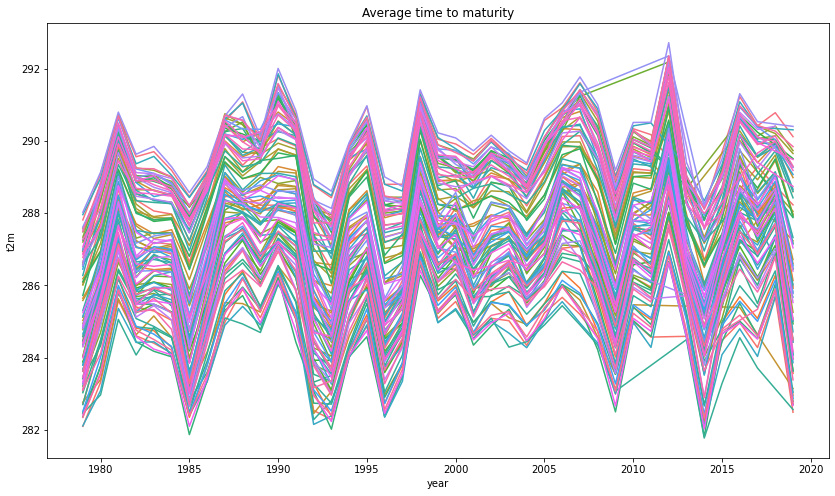

In [18]:
fig, ax = plt.subplots(figsize=(14,8))
sns.lineplot(ax=ax,data=avg_ERA5, x="year", y="t2m", hue="county", legend=False)
plt.title('Average time to maturity')

In [19]:
yield_df.head()

,year,county,yield
0,2019,LOGAN,194.2
1,2019,MACON,204.4
2,2019,MARSHALL,184.9
3,2019,MASON,169.0
4,2019,MCLEAN,198.8


Actually predicting on just the county and the year


In [20]:
stacked_df.head()

,year,county,long,lat,evi_1,evi_17,evi_33,evi_49,evi_65,evi_81,...,evi_209,evi_225,evi_241,evi_257,evi_273,evi_289,evi_305,evi_321,evi_337,evi_353
0,2001,ADAMS,-91.525,40.075,-0.146923,0.156453,-0.072903,-0.063690,-0.078860,-0.292650,...,-0.287875,0.127960,0.630331,0.057551,0.028800,0.224734,-0.037140,-0.054813,0.095283,0.132038
1,2001,ADAMS,-91.525,40.125,-0.156214,-0.188116,-0.091597,-0.109840,-0.099103,0.021988,...,0.226016,0.078727,-0.084846,0.029688,0.003740,-0.170605,-0.061510,-0.064935,-0.092197,-0.100994
2,2001,ADAMS,-91.525,40.175,0.000551,0.082851,0.108108,0.104726,0.101105,0.126727,...,0.455470,0.454312,0.411025,0.357470,0.320813,0.237779,0.165385,0.161586,0.142840,0.017134
3,2001,ADAMS,-91.525,40.225,-0.005583,0.084916,0.116382,0.115102,0.107363,0.130750,...,0.436069,0.462088,0.436204,0.374752,0.330077,0.250325,0.180660,0.169659,0.148152,0.017000
4,2001,ADAMS,-91.475,39.975,-0.030379,0.079086,0.107433,0.092655,0.078413,0.107965,...,0.544530,0.531395,0.461023,0.335277,0.239753,0.155304,0.102718,0.097096,0.079518,0.084052


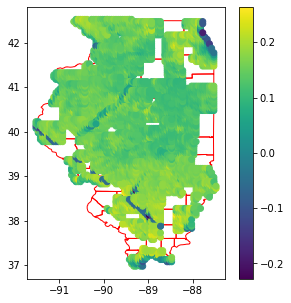

In [38]:
df_plot = ERA5_df[ERA5_df["year"]==2019]

fig, ax = plt.subplots(figsize=(5, 5))
gdf.plot(ax=ax, facecolor='none', edgecolor='red')
plt.scatter(df_plot["long"], df_plot["lat"], c=df_plot["evi_1"])
plt.colorbar()

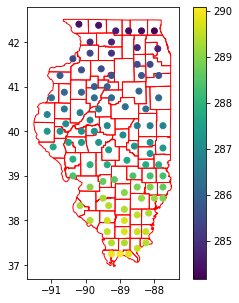

In [23]:
df_plot = avg_ERA5_graphic
# df_plot = ERA5_df[ERA5_df["year"]==2019]

fig, ax = plt.subplots(figsize=(5, 5))
gdf.plot(ax=ax, facecolor='none', edgecolor='red')
plt.scatter(df_plot["long"], df_plot["lat"], c=df_plot["t2m"])
plt.colorbar()

EVIs

In [24]:
stacked_df

,year,county,long,lat,evi_1,evi_17,evi_33,evi_49,evi_65,evi_81,...,evi_209,evi_225,evi_241,evi_257,evi_273,evi_289,evi_305,evi_321,evi_337,evi_353
0,2001,ADAMS,-91.525,40.075,-0.146923,0.156453,-0.072903,-0.063690,-0.078860,-0.292650,...,-0.287875,0.127960,0.630331,0.057551,0.028800,0.224734,-0.037140,-0.054813,0.095283,0.132038
1,2001,ADAMS,-91.525,40.125,-0.156214,-0.188116,-0.091597,-0.109840,-0.099103,0.021988,...,0.226016,0.078727,-0.084846,0.029688,0.003740,-0.170605,-0.061510,-0.064935,-0.092197,-0.100994
2,2001,ADAMS,-91.525,40.175,0.000551,0.082851,0.108108,0.104726,0.101105,0.126727,...,0.455470,0.454312,0.411025,0.357470,0.320813,0.237779,0.165385,0.161586,0.142840,0.017134
3,2001,ADAMS,-91.525,40.225,-0.005583,0.084916,0.116382,0.115102,0.107363,0.130750,...,0.436069,0.462088,0.436204,0.374752,0.330077,0.250325,0.180660,0.169659,0.148152,0.017000
4,2001,ADAMS,-91.475,39.975,-0.030379,0.079086,0.107433,0.092655,0.078413,0.107965,...,0.544530,0.531395,0.461023,0.335277,0.239753,0.155304,0.102718,0.097096,0.079518,0.084052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95413,2019,WOODFORD,-88.975,40.875,0.104419,-0.036563,0.101393,0.092699,0.106869,0.122912,...,0.625691,0.686203,0.650799,0.520993,0.358112,0.226376,0.176463,0.161508,0.130636,0.117372
95414,2019,WOODFORD,-88.975,40.925,0.107272,-0.041136,0.090257,0.119536,0.109404,0.117849,...,0.612463,0.673483,0.637218,0.508683,0.357745,0.241118,0.164970,0.130541,0.129778,0.109219
95415,2019,WOODFORD,-88.925,40.825,0.107422,-0.039893,0.103312,0.089351,0.106749,0.120598,...,0.630736,0.684656,0.647539,0.525632,0.362510,0.218094,0.176306,0.171923,0.131405,0.113442
95416,2019,WOODFORD,-88.925,40.875,0.106712,-0.039885,0.101711,0.090369,0.109686,0.125570,...,0.606228,0.654604,0.608509,0.479529,0.334070,0.232092,0.193145,0.171825,0.129873,0.116098


In [25]:
avg_EVI = stacked_df.groupby(['county', 'year'],as_index=False).mean()
avg_EVI

,county,year,long,lat,evi_1,evi_17,evi_33,evi_49,evi_65,evi_81,...,evi_209,evi_225,evi_241,evi_257,evi_273,evi_289,evi_305,evi_321,evi_337,evi_353
0,ADAMS,2001,-91.196635,39.991827,-0.031036,0.089801,0.123581,0.115850,0.113604,0.143374,...,0.554475,0.513934,0.411826,0.310377,0.265210,0.208389,0.167336,0.160516,0.149531,0.127763
1,ADAMS,2002,-91.196635,39.991827,0.117097,0.124210,0.117512,0.114990,0.127489,0.159386,...,0.535022,0.522062,0.455333,0.336883,0.227270,0.194303,0.167694,0.130103,0.130739,0.110763
2,ADAMS,2003,-91.196635,39.991827,0.121478,0.015937,0.095923,0.089998,0.093110,0.141453,...,0.603676,0.517173,0.431676,0.344670,0.250815,0.206314,0.173535,0.148430,0.092837,0.021009
3,ADAMS,2004,-91.225962,40.107692,0.123930,0.127315,-0.003415,0.132156,0.147215,0.192158,...,0.599342,0.544142,0.388240,0.298843,0.256964,0.194539,0.167473,0.130497,0.145724,0.130064
4,ADAMS,2005,-91.196635,39.991827,0.038249,0.113797,0.127036,0.122267,0.117654,0.128124,...,0.499190,0.469464,0.368509,0.275002,0.247870,0.225127,0.209727,0.146473,0.056386,0.070453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1370,WOODFORD,2013,-89.231627,40.782229,0.100374,0.135401,0.131670,0.120397,0.119557,0.140125,...,0.685163,0.651363,0.519344,0.388649,0.226219,0.209983,0.160728,0.139518,0.137797,0.102930
1371,WOODFORD,2015,-89.231627,40.782229,0.009158,0.116672,-0.022646,0.008288,0.118866,0.152283,...,0.636619,0.648269,0.537029,0.271992,0.221613,0.203212,0.151440,0.134438,0.141042,0.134851
1372,WOODFORD,2016,-89.231627,40.782229,0.101230,0.140205,0.132381,0.156158,0.145093,0.168446,...,0.697362,0.661831,0.473479,0.270571,0.217684,0.213186,0.182424,0.178477,0.181539,0.144898
1373,WOODFORD,2017,-89.231627,40.782229,0.142253,0.146763,0.142850,0.156188,0.164162,0.152968,...,0.677637,0.652121,0.575497,0.402988,0.257138,0.192192,0.160847,0.151070,0.150023,0.139142


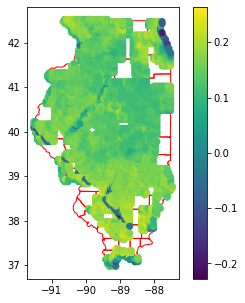

In [26]:
df_plot = stacked_df[stacked_df["year"]==2019]

fig, ax = plt.subplots(figsize=(5, 5))
gdf.plot(ax=ax, facecolor='none', edgecolor='red')
plt.scatter(df_plot["long"], df_plot["lat"], c=df_plot["evi_1"])
plt.colorbar()

In [56]:
# split training data
from sklearn import model_selection as ms
prediction = yield_df['yield']
print(prediction.shape)
input = yield_df[['county', 'year']]
print(input.shape)

# works fine 
yield_train, yield_test, input_train, input_test = ms.train_test_split(prediction, input, test_size=0.2, random_state=42)

# throws error
yield_train, yield_test, input_train, input_test = ms.train_test_split(prediction, input, test_size=0.2, random_state=42, stratify = counties)

print(yield_train)
print(yield_test)

(9622,)
(9622, 2)
9197     39.0
1253    154.0
1369    142.0
4638     91.0
3344    137.0
        ...  
5734     79.0
5191     59.0
5390     94.0
860     169.5
7270     58.0
Name: yield, Length: 7697, dtype: float64
1078    170.0
2098    126.0
9384     27.0
5425     85.0
7735     58.0
        ...  
2485    172.0
7063     53.0
2157    133.0
4103    126.0
8782     10.0
Name: yield, Length: 1925, dtype: float64
